### city_map_list
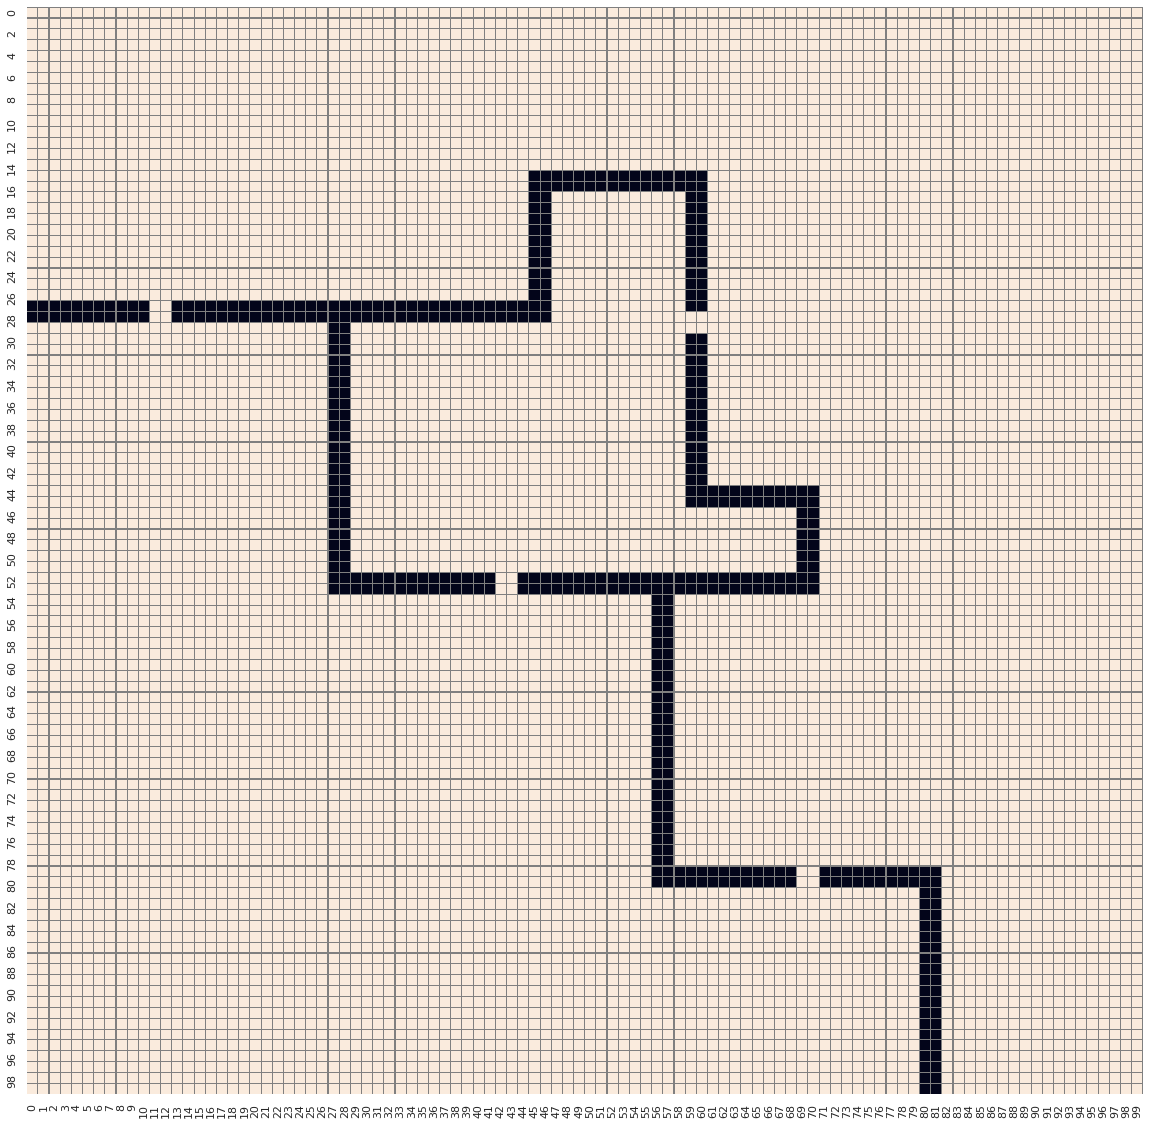

# Задачая

Вам известно: Местоположение курьера, Набор координат мест назначения и Карта города. 

Теперь нужно написать скрипт, который создаст переменную route и сохранит в нее маршрут, по которому должен пройти курьер, чтобы разнести все доставки. При формировании маршрута необходимо выполнить следующие условия:

- Маршрут должен проходить только по земле, по воде ходить нельзя. 
- Курьеры могут перемещаться на один шаг из текущего района вправо, влево, вниз или вверх. 
- Маршрут должен быть сохранен в список, где каждый элемент, это tuple с координатами каждого шага курьера.
- Курьер проходит один шаг за 10 минут и может доставлять заказы в любом порядке.

# Единое решение

In [1]:
# Библиотеки
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
start_time = time.time()





# Начальные данные
courier_location = (17, 99)

orders_location = [(42, 76), (27, 80), (43, 52), (26, 75)]

url='https://drive.google.com/uc?id=1-crPzL6qMinByPzsrEHhGn1EJ1MfD3GX'
df = pd.read_csv(url, names=list(range(0, 100, 1)))
city_map_list = df.values.tolist()

print(f'courier_location = {courier_location}\n\norders_location = {orders_location}')


# Варианты начальных данных

# courier_location = (2, 2)
# orders_location = [(4, 0), (0, 2), (4, 3)]

# courier_location = (10, 10)
# orders_location = [(1, 1), (92, 13), (46, 33)]

# courier_location = (84, 17)
# orders_location = [(66, 32), (39, 75), (90, 10), (89, 60), (79, 77), (65, 38), (9, 5)]

# courier_location = (17, 99)
# orders_location = [(42, 76), (27, 80), (43, 52), (26, 75)]





# Визуализация города (Белым нарисована земля, Синим река)
route_map = city_map_list.copy()
route_map = np.array(route_map)





# Назначение веса по умолчанию
# Это особое if, которое вытекает из тестовой структуры курса. 
# Когда тесты выполняются в цикле, каждый объект карты города будет переопределен следующим кодом, 
# поэтому мы должны быть уверены, что мы не переопределяем наши веса дополнительными 0-s

if city_map_list[1][1] == 1:
    for i in range(100):
        for j in range(100):
            if city_map_list[i][j] == 1:
                city_map_list[i][j] = [1, float('inf')]
            else:
                city_map_list[i][j] = [0, float('inf')]
map_len = len(city_map_list[0]) - 1
# распределение веса должности курьера
city_map_list[courier_location[1]][courier_location[0]][1] = 0





# Получение соседних узлов
def get_adjacent_nodes(node):
    nodes = []
    # Найдем, есть ли какие-либо невозможные индексы (границы карты)
    # Если нет, то это где-то за пределами границ. Давайте проверим каждую сторону
    if node[0] < map_len:
        if city_map_list[node[1]][node[0] + 1][0] == 1:  # Правая
            nodes.append((node[0] + 1, node[1]))
    if node[1] > 0:
        if city_map_list[node[1] - 1][node[0]][0] == 1:  # Верхняя
            nodes.append((node[0], node[1] - 1))
    if node[1] < map_len:
        if city_map_list[node[1] + 1][node[0]][0] == 1:  # Нижняя
            nodes.append((node[0], node[1] + 1))
    if node[0] > 0:
        if city_map_list[node[1]][node[0] - 1][0] == 1:  # Левая
            nodes.append((node[0] - 1, node[1]))
    return nodes





# Создание маршрута
def build_path(to_node, previous_path):
    # previous path использовался dict с actual_node в качестве ключа и previous_node в качестве значения, 
    # которое мы использовали для распаковки этого dict в допустимый путь после обнаружения целевого узла
    path = []
    while previous_path.get(to_node):
        path.append(to_node)
        to_node = previous_path[to_node]
    # print(f"Previous path is {previous_path}")
    return path[::-1]





# Эвристика
def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)





# Выбор узла с помощью эвристической функции
def choose_node(reachable, end_node):
    min_cost = float('Inf')
    best_node = None
    for node in reachable:
        cost_start_to_node = city_map_list[node[1]][node[0]][1]
        cost_node_to_goal = heuristic(node, end_node)
        total_cost = cost_start_to_node + cost_node_to_goal

        if min_cost > total_cost:
            min_cost = total_cost
            best_node = node
    return best_node





# Поиск пути
def find_path(start_node, end_node):
    # создание двух списков с доступными и исследованными узлами
    reachable = [start_node]
    explored = []
    previous_path = {}
    # Создание цикла нахождения пути
    while reachable:
        # Выбор узла
        node = choose_node(reachable, end_node)
        # testing positions
        # print(f"current node:{node}{city_map_list[node[1]][node[0]][1]}")
        # print(f"reachable nodes:{reachable}")
        # print(f"explored nodes:{explored}")

        # Если мы находимся в целевом узле, строим маршрут и возвращаемся
        if node == end_node:
            return build_path(end_node, previous_path)

        # не повторяем исследованные узлы
        reachable.remove(node)
        explored.append(node)

        # Чтоб определиться куда идти дальше
        # Используем разницу для нахождения новых узлов. 
        new_reachable = [variant for variant in get_adjacent_nodes(node) if variant not in explored]
        # При помощи использованных узлов, находим новые

        for adjacent in new_reachable:
            if adjacent not in reachable:
                reachable.append(adjacent)
                previous_path[adjacent] = node  # Последним шагом для перехода к узлу мы сохраняем все узлы
            # Небольшая хитрость для ускорения поиска узлов - присвоение веса
            if city_map_list[node[1]][node[0]][1] + 1 <= city_map_list[adjacent[1]][adjacent[0]][1]:
                city_map_list[adjacent[1]][adjacent[0]][1] = city_map_list[node[1]][node[0]][1] + 1

    # Если пути нет
    return None





# Заполнение маршрута координатами пути
route = []
start_pos = courier_location
for i in range(len(orders_location)):
    route.extend(find_path(start_pos, orders_location[i]))
    start_pos = find_path(start_pos, orders_location[i])[-1]

    
    

    
# Автоматическое тестирование результирующего маршрута
print(f"\n\nRoute is \n{route}")
for i in orders_location:
    for j in route:
        if i == j:
            print(f"found {i}")
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ', elapsed_time)





# Визуализация найденого пути
# Карта маршрута

route_map*=50000
sns.set()

for i in route:
    route_map[i[1],i[0]] += 10000

for i in orders_location:
    route_map[i[1],i[0]] = 15000

print('\n\nКарта маршрута')

plt.figure(figsize = (22,18))
sns.heatmap(route_map, cbar= False, cmap="coolwarm")

courier_location = (17, 99)

orders_location = [(42, 76), (27, 80), (43, 52), (26, 75)]


IndexError: list index out of range